In [2]:
## Importing required packages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from typing import TypedDict, Annotated, Literal

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langgraph.graph import add_messages
import operator

import os

## Libraries to retain memory
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
## Initiating the environment
load_dotenv()

## Defining and initiating llm
model = ChatPerplexity(model= 'sonar', api_key= os.getenv("PERPLEXITY_API_KEY"))

In [6]:
## Defining state
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [7]:
## Defining funtions that needs to be executed while invoking graph
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = model.invoke(prompt).content

    return {'joke': response}
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = model.invoke(prompt).content

    return {'explanation': response}

In [10]:
## Defining graph
graph = StateGraph(JokeState)

## Add nodes
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

## Add edges
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

## Add check pointers
checkpointer = InMemorySaver()

## Compiling workflow
workflow = graph.compile(checkpointer=checkpointer)

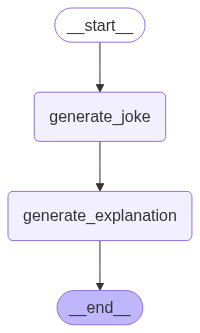

In [12]:
## Visualize the graph
workflow

In [14]:
## Setting up the configuration and invoking the graph
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {'topic' : 'pizza'}
final_state = workflow.invoke(initial_state, config= config1)
print(final_state)

{'topic': 'pizza', 'joke': 'Why did the hipster burn his mouth on the pizza?  \nBecause he ate it before it was cool!  \n\nThis classic pizza joke plays on the idea of hipsters liking things before they become popular, combining it with the literal meaning of eating hot pizza too soon[1][3][5].', 'explanation': 'The joke "Why did the hipster burn his mouth on the pizza? Because he ate it before it was cool!" is a play on the dual meaning of the phrase "before it was cool." \n\n**Explanation:**\n\n- **Hipsters** are stereotypically known for liking things before they become popular or trendy—i.e., *before they are "cool"* in the cultural sense.\n- The joke twists this by applying the phrase literally to pizza temperature: the hipster ate the pizza *before it was cool* (before it cooled down from being hot), causing him to burn his mouth.\n- This combines the cultural stereotype with a literal outcome, making the humor come from the pun on "cool" referring to both temperature and trendin

In [17]:
## 1. Checking final state
workflow.get_state(config= config1)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the hipster burn his mouth on the pizza?  \nBecause he ate it before it was cool!  \n\nThis classic pizza joke plays on the idea of hipsters liking things before they become popular, combining it with the literal meaning of eating hot pizza too soon[1][3][5].', 'explanation': 'The joke "Why did the hipster burn his mouth on the pizza? Because he ate it before it was cool!" is a play on the dual meaning of the phrase "before it was cool." \n\n**Explanation:**\n\n- **Hipsters** are stereotypically known for liking things before they become popular or trendy—i.e., *before they are "cool"* in the cultural sense.\n- The joke twists this by applying the phrase literally to pizza temperature: the hipster ate the pizza *before it was cool* (before it cooled down from being hot), causing him to burn his mouth.\n- This combines the cultural stereotype with a literal outcome, making the humor come from the pun on "cool" referring to both te

In [19]:
## 1. Checking partial states
list(workflow.get_state_history(config= config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the hipster burn his mouth on the pizza?  \nBecause he ate it before it was cool!  \n\nThis classic pizza joke plays on the idea of hipsters liking things before they become popular, combining it with the literal meaning of eating hot pizza too soon[1][3][5].', 'explanation': 'The joke "Why did the hipster burn his mouth on the pizza? Because he ate it before it was cool!" is a play on the dual meaning of the phrase "before it was cool." \n\n**Explanation:**\n\n- **Hipsters** are stereotypically known for liking things before they become popular or trendy—i.e., *before they are "cool"* in the cultural sense.\n- The joke twists this by applying the phrase literally to pizza temperature: the hipster ate the pizza *before it was cool* (before it cooled down from being hot), causing him to burn his mouth.\n- This combines the cultural stereotype with a literal outcome, making the humor come from the pun on "cool" referring to both t

Cool, new lets invoke another joke and check the functionality of thread_id in Persistence.

In [ ]:
## Setting up the configuration and invoking the graph for another topic
config2 = {"configurable": {"thread_id": "2"}}
initial_state = {'topic' : 'dosa'}
final_state = workflow.invoke(initial_state, config= config2)
print(final_state)

{'topic': 'dosa', 'joke': 'Why did the dosa go to therapy? Because it couldn’t stop flipping out!  \n\nAlternatively: Why did the dosai get a perm? Because it wanted to be a fancy crepe![1]', 'explanation': 'The joke "Why did the dosa go to therapy? Because it couldn’t stop flipping out!" plays on a double meaning of the phrase "flipping out." In one sense, "flipping out" means losing control or getting very upset, which is a common expression related to emotional distress. In the context of dosa, a South Indian crepe-like pancake, "flipping out" humorously refers to the cooking process where the dosa batter is spread thin on a hot plate (tava) and frequently flipped or turned to cook evenly[1][2]. So, the dosa "going to therapy" because it "couldn\'t stop flipping out" is a pun mixing the emotional meaning with the literal cooking action.\n\nSimilarly, the alternative joke, "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" is a wordplay linking the dosa (also call

In [ ]:
## 1. Checking final state thread_id 2
workflow.get_state(config= config2)

StateSnapshot(values={'topic': 'dosa', 'joke': 'Why did the dosa go to therapy? Because it couldn’t stop flipping out!  \n\nAlternatively: Why did the dosai get a perm? Because it wanted to be a fancy crepe![1]', 'explanation': 'The joke "Why did the dosa go to therapy? Because it couldn’t stop flipping out!" plays on a double meaning of the phrase "flipping out." In one sense, "flipping out" means losing control or getting very upset, which is a common expression related to emotional distress. In the context of dosa, a South Indian crepe-like pancake, "flipping out" humorously refers to the cooking process where the dosa batter is spread thin on a hot plate (tava) and frequently flipped or turned to cook evenly[1][2]. So, the dosa "going to therapy" because it "couldn\'t stop flipping out" is a pun mixing the emotional meaning with the literal cooking action.\n\nSimilarly, the alternative joke, "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" is a wordplay linkin

In [ ]:
## 1. Checking partial states of thread_id 2
list(workflow.get_state_history(config= config2))

[StateSnapshot(values={'topic': 'dosa', 'joke': 'Why did the dosa go to therapy? Because it couldn’t stop flipping out!  \n\nAlternatively: Why did the dosai get a perm? Because it wanted to be a fancy crepe![1]', 'explanation': 'The joke "Why did the dosa go to therapy? Because it couldn’t stop flipping out!" plays on a double meaning of the phrase "flipping out." In one sense, "flipping out" means losing control or getting very upset, which is a common expression related to emotional distress. In the context of dosa, a South Indian crepe-like pancake, "flipping out" humorously refers to the cooking process where the dosa batter is spread thin on a hot plate (tava) and frequently flipped or turned to cook evenly[1][2]. So, the dosa "going to therapy" because it "couldn\'t stop flipping out" is a pun mixing the emotional meaning with the literal cooking action.\n\nSimilarly, the alternative joke, "Why did the dosai get a perm? Because it wanted to be a fancy crepe!" is a wordplay linki